# Setup OU model

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload
import torch
import time
import doobhtransform as doob
from doobhtransform.utils import normal_logpdf

In [4]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Computing on " + str(device))

Computing on cpu


In [74]:
# tuning parameters
d = 2 # dimension of latent state
std_obs = 0.5
theta = {}


# Latent process

In [75]:
# dict for objects relating to latent process
state = {}

# dimension of state
state["dim"] = d

# drift of diffusion
beta = torch.tensor(1.0, device = device) 
b = lambda theta, x: - beta * x 
state["drift"] = b

# diffusion coefficient of diffusion
sigma = torch.tensor(1.0, device=device)
state["sigma"] = sigma

# simulate initial states (from stationary distribution)
rinit = lambda N: (sigma / torch.sqrt(2.0 * beta)) * torch.randn(N, d, device=device)
state["rinit"] = rinit

# Observation model

In [103]:
# dict for objects relating to observations
obs = {}

# dimension of observation
p = d
obs["dim"] = p

# number of observations
T = 10
obs["num_obs"] = T

# observation time interval
interval = 1.0
obs["interval"] = interval

# observation parameters
var_obs = torch.tensor(std_obs**2, device=device)  # variance of observation

# log-observation density
obs_log_density = lambda theta, x, y: normal_logpdf(
    y, x, var_obs
)  # terminal condition, returns size (N)
obs["log_density"] = obs_log_density

# simulate observations
def observation(N):
    X = rinit(N) # (N, d)
    Y = torch.zeros(N, T, p, device=device)
    for t in range(T):
        X = X * torch.exp(-beta * interval) + torch.sqrt(
            (1.0 - torch.exp(-2.0 * beta * interval)) / (2.0 * beta)
        ) * torch.randn(1, d, device=device)
        Y[:, t, :] = X + std_obs * torch.randn(1, p, device=device)
    return Y
# observation = lambda N: rinit(N * T).reshape((N, T, d)) + std_obs * torch.randn(N, T, p, device=device)
obs["robs"] = observation

# Simulate states and observations

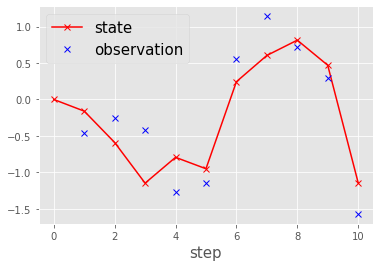

In [104]:
# simulate states and observations
X = torch.zeros(T + 1, d, device=device)
Y = torch.zeros(T, p, device=device)
for t in range(T):
    X[t + 1, :] = X[t, :] * torch.exp(- beta * interval) + torch.sqrt(
        (1.0 - torch.exp(-2.0 * beta * interval)) / (2.0 * beta)
    ) * torch.randn(1, d, device=device)
    Y[t, :] =  X[t + 1, :] + std_obs * torch.randn(1, p, device=device)
X0 = X[0, ]
obs["sequence"] = Y

# plot states and observations
plt.figure()
plt.plot(torch.arange(T + 1), X[:, 0].cpu(), "r-x")
plt.plot(torch.arange(1, T + 1), Y[:, 0].cpu(), "bx")
plt.xlabel("step", fontsize=15)
plt.legend(["state", "observation"], fontsize=15)
plt.show()

# Train model

In [105]:
# algorithm settings
M = 20
num_steps = M
V_net_config = {"layers": [16]}
Z_net_config = {"layers": [16]}
net_config = {"V": V_net_config, "Z": Z_net_config}
model = doob.core.model(state, obs, num_steps, net_config, device)

# optimization configuration
optim_config = {
    "minibatch": 100,
    "num_iterations": 1000,
    "learning_rate": 1e-2,
    "weight_decay": 1e-2,
    "initial_required": True,
}

# training
time_start = time.time()
model.train(theta, optim_config)
time_end = time.time()
time_elapsed = time_end - time_start
print("Training time (secs): " + str(time_elapsed))

  0%|          | 2/1000 [00:00<01:19, 12.55it/s]

Optimization iteration: 1 Loss: 235.4840087890625


 10%|█         | 102/1000 [00:08<01:11, 12.49it/s]

Optimization iteration: 100 Loss: 110.80514526367188


 20%|██        | 202/1000 [00:16<01:03, 12.60it/s]

Optimization iteration: 200 Loss: 96.01484680175781


 30%|███       | 302/1000 [00:24<00:57, 12.16it/s]

Optimization iteration: 300 Loss: 71.58414459228516


 40%|████      | 402/1000 [00:32<00:47, 12.71it/s]

Optimization iteration: 400 Loss: 21.04957389831543


 50%|█████     | 502/1000 [00:39<00:38, 12.95it/s]

Optimization iteration: 500 Loss: 29.96207046508789


 60%|██████    | 602/1000 [00:47<00:31, 12.55it/s]

Optimization iteration: 600 Loss: 12.072068214416504


 70%|███████   | 702/1000 [00:55<00:22, 13.11it/s]

Optimization iteration: 700 Loss: 9.451581954956055


 80%|████████  | 802/1000 [01:03<00:16, 12.21it/s]

Optimization iteration: 800 Loss: 7.920137882232666


 90%|█████████ | 902/1000 [01:11<00:07, 12.48it/s]

Optimization iteration: 900 Loss: 9.019782066345215


100%|██████████| 1000/1000 [01:19<00:00, 12.64it/s]

Optimization iteration: 1000 Loss: 8.397955894470215
Training time (secs): 79.10966682434082


In [10]:
# more training
optim_config["initial_required"] = False
time_start = time.time()
model.train(theta, optim_config)
time_end = time.time()
time_elapsed = time_end - time_start
print("Training time (secs): " + str(time_elapsed))

  0%|          | 0/1000 [00:00<?, ?it/s]

Optimization iteration: 1 Loss: 10.09260082244873


 10%|█         | 102/1000 [00:07<01:11, 12.60it/s]

Optimization iteration: 100 Loss: 11.28891658782959


 20%|██        | 202/1000 [00:15<01:02, 12.75it/s]

Optimization iteration: 200 Loss: 11.817627906799316


 30%|███       | 302/1000 [00:22<00:50, 13.71it/s]

Optimization iteration: 300 Loss: 10.265093803405762


 40%|████      | 402/1000 [00:30<00:46, 12.94it/s]

Optimization iteration: 400 Loss: 11.357498168945312


 50%|█████     | 502/1000 [00:37<00:36, 13.65it/s]

Optimization iteration: 500 Loss: 9.722755432128906


 60%|██████    | 602/1000 [00:45<00:30, 13.23it/s]

Optimization iteration: 600 Loss: 9.897615432739258


 70%|███████   | 702/1000 [00:52<00:22, 13.16it/s]

Optimization iteration: 700 Loss: 10.62648868560791


 80%|████████  | 802/1000 [01:00<00:14, 13.36it/s]

Optimization iteration: 800 Loss: 11.557048797607422


 90%|█████████ | 902/1000 [01:07<00:07, 13.74it/s]

Optimization iteration: 900 Loss: 9.841341972351074


100%|██████████| 1000/1000 [01:15<00:00, 13.28it/s]

Optimization iteration: 1000 Loss: 11.05733871459961
Training time (secs): 75.29039907455444


# Run SMC

In [106]:
N = 2**10

In [107]:
_states, _ess, _log_norm_const, _log_ratio_norm_const = (
    model.simulate_uncontrolled_SMC(theta, X0, Y, N, resample=True, full_path=True)
)
print("Log-likelihood estimate: " + str(float(_log_ratio_norm_const)))

Log-likelihood estimate: -25.72178077697754


In [108]:
states, ess, log_norm_const, log_ratio_norm_const = (
    model.simulate_controlled_SMC(theta, X0, Y, N, resample=True, full_path=True)
)
print("Log-likelihood estimate: " + str(float(log_ratio_norm_const)))

Log-likelihood estimate: -25.450937271118164


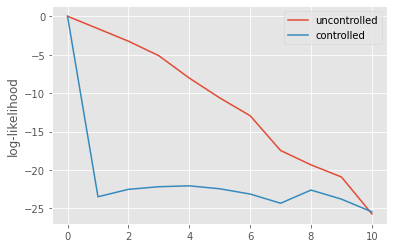

In [109]:
plt.figure()
plt.plot(_log_norm_const)
plt.plot(log_norm_const)
plt.ylabel("log-likelihood")
plt.legend(["uncontrolled", "controlled"])

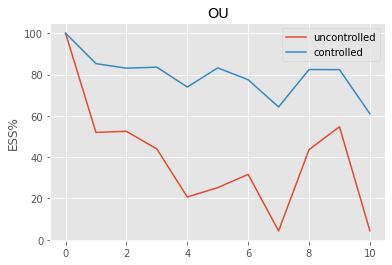

In [113]:
plt.figure()
plt.plot(_ess * 100 / N)
plt.plot(ess * 100 / N)
plt.ylabel("ESS%")
plt.title("OU")
plt.legend(["uncontrolled", "controlled"])

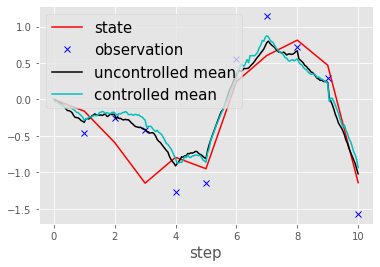

In [112]:
# plot states and observations (for full_path = False)
times = torch.linspace(0.0, T * interval, T * M + 1, device=device)
plt.figure()
plt.plot(torch.arange(T + 1), X[:, 0], "r-")
plt.plot(torch.arange(1, T + 1), Y[:, 0], "bx")
plt.plot(times, torch.mean(states[:, :, 0], 0), "k-")
plt.plot(times, torch.mean(_states[:, :, 0], 0), 'c-')
# for n in range(N):
    # plt.plot(times, states[n, :, 0], 'k.', alpha = 0.01)
plt.xlabel("step", fontsize=15)
plt.legend(["state", "observation", "uncontrolled mean", "controlled mean"], fontsize=15)
plt.show()